# Federations vs. simple risk splitting

After a recent [Twitter discussion](https://twitter.com/liber_liver/status/1453654819227512834) I wanted to explore how much better federated custodians protect against malicious actors than naively splitting one's capital over multiple centralized custodians. We assume that each federation member/custodian has a probability $P_{mal}$ of being malicios.

We are now interested in the expected loss $E(\text{loss})$ a user suffers due to that. Loss is defined as losing access to their funds. In the federated setting that can be either due to theft or due to the adversary stopping the federation (which is easier). There exist countermeasures against adversaries merely stopping the federation (e.g. for ransom) but we will pessimistically assume that both failure modes mean loss of funds for the user (even if only for a limited time). In the centralized custodial case on the other hand the money gets stolen or not.

We explore both federations of optimal sizes $(i \cdot 3) + 1$ for as well as federations of suboptimal sizes. We see that adding members to a federation of already optimal size hurts resilience in our model since there are more potentially malicious parties but the threshold for how many malicious parties the system can handle does not change. This particular optimality number stems from the fact that we consider frozen funds as lost (since there is potential for blackmail etc.). This happens when the liveness of our consensus algorithm [HBBFT](https://eprint.iacr.org/2016/199.pdf) is no longer guaranteed.

In [1]:
def max_faulty_liveness(n):
    """Returns maximum the number of malicious federation members for liveness"""
    return (n - 1) // 3

def max_faulty_fund_safety(n):
    """Returns maximum the number of malicious federation members for fund safety"""
    return n - max_faulty_liveness(n) - 1

def p_mal_fail(n, mal, pmal):
    """
    Returns the probability of mal of n members being malicious given the
    single-member-malicious probability pmal.
    """
    return binomial(n, mal) * pmal**mal * (1 - pmal)**(n - mal)

In [2]:
def fedi_stall_prob(n, pmal):
    """probability of the federation stalling"""
    return sum([p_mal_fail(n, mal, pmal) for mal in range(max_faulty_liveness(n) + 1, max_faulty_fund_safety(n) + 1)])

def fedi_theft_prob(n, pmal):
    """probability of the federation's funds getting stolen"""
    return sum([p_mal_fail(n, mal, pmal) for mal in range(max_faulty_fund_safety(n) + 1, n + 1)])

def fedi_inaccessible_prob(n, pmal):
    """probability of user funds in the federation being inaccessible"""
    return fedi_stall_prob(n, pmal) + fedi_theft_prob(n, pmal)

def fedi_exp_loss(n, pmal, funds):
    """expected loss (inaccessible funds) of a federation user"""
    return funds * fedi_inaccessible_prob(n, pmal)

In [3]:
def hc_split_exp_loss(n, pmal, funds):
    """expected loss (inaccessible funds) of a user splitting funds over n single cusatodians"""
    return sum([p_mal_fail(n, mal, pmal) * (mal * funds / n) for mal in range(1, n + 1)])

In [4]:
def graph_fedsizes_baseline(sizes, pmin=0, pmax=1, title=None):
    plots = [hc_split_exp_loss(4, x, 1)] + [fedi_exp_loss(n, x, 1) for n in sizes]
    labels = ["split over n"] + ["federation of $n={}$".format(n) for n in sizes]
    return plot(plots, (x, pmin, pmax), legend_label=labels, axes_labels=['$P_{mal}$','E(loss)'], title=title)

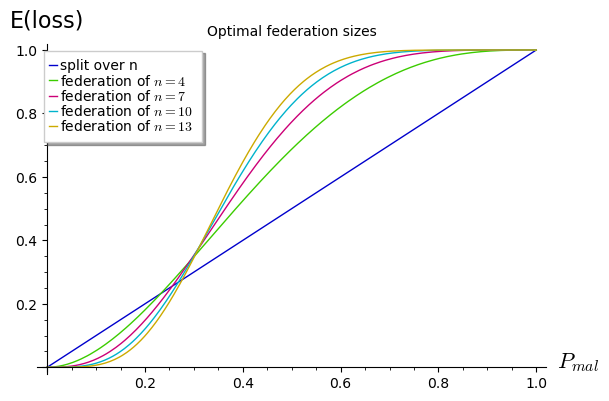

In [5]:
# Optimal federation sizes
graph_fedsizes_baseline([i * 3 + 1 for i in range(1, 5)], title="Optimal federation sizes")

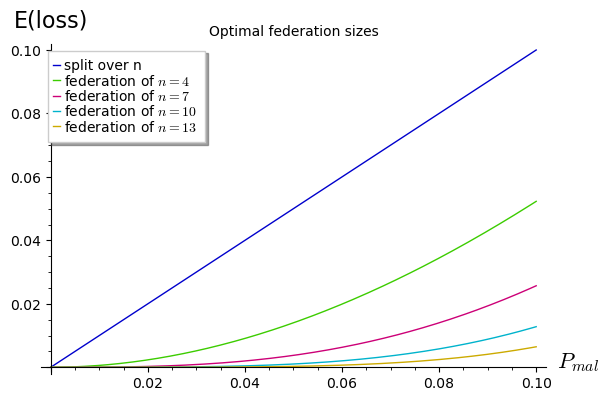

In [6]:
# Optimal federation sizes, details
graph_fedsizes_baseline([i * 3 + 1 for i in range(1, 5)], pmax=0.1, title="Optimal federation sizes")

We see that for low probabilities of peers being malicious federations perform far better. Furthermore the intersection of the federation curve with the split curve happens at a higher $P_{mal}$ for larger federation sizes. This intersection marks the point at which federations become worse than just splitting funds over custodians. But since for all federation sizes this is above 20%, meaning a service provider/federation member would want to scam users with 20% probability, it can be seen as irrelevant. If users have to fear their service providers that much they should not use them in the first place.

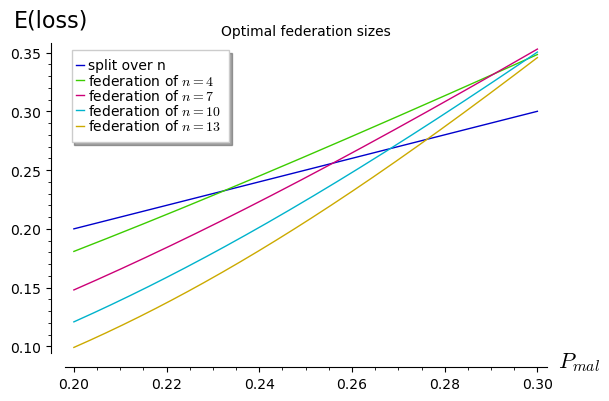

In [7]:
# Optimal federation sizes, intersections
graph_fedsizes_baseline([i * 3 + 1 for i in range(1, 5)], pmin=0.2, pmax=0.3, title="Optimal federation sizes")

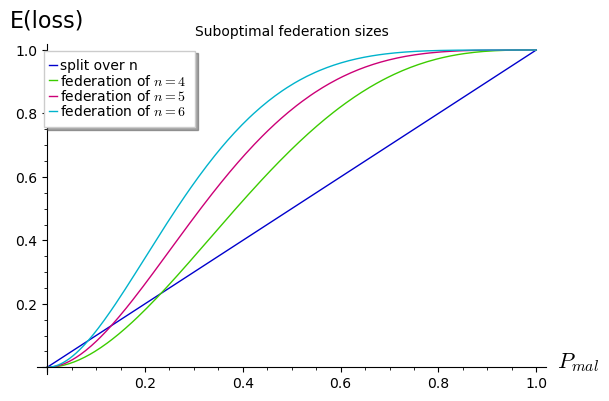

In [8]:
# Optimal to suboptimal federation sizes
graph_fedsizes_baseline([4, 5, 6], title="Suboptimal federation sizes")

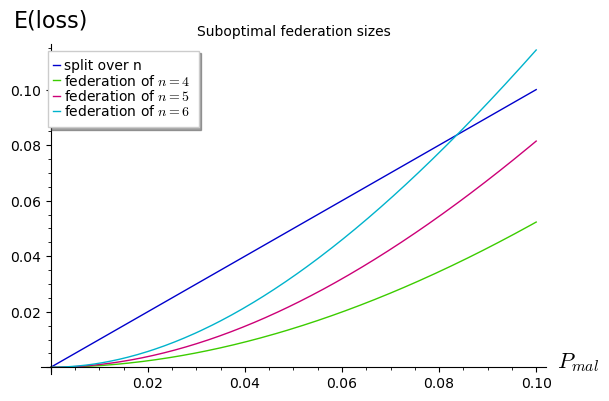

In [9]:
# Optimal to suboptimal federation sizes, details
graph_fedsizes_baseline([4, 5, 6], pmax=0.1, title="Suboptimal federation sizes")